Here the simulation of two interacting atoms is done for the thesis work.

starting from the hamiltonian of the singol atom coupled with the lasers
$$ H_0 = \hbar
\begin{pmatrix}
    0 & \Omega_b/2 & 0 \\
    \Omega_b/2 & - \Delta_{blue} &  \Omega_{IR}/2 \\
    0 & \Omega_{IR}/2 & - \Delta_{IR}
\end{pmatrix}
$$

we write the interaction between the two atoms
$$ H_{int} = U_{int}
\begin{pmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 1 \\
\end{pmatrix} \otimes
\begin{pmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 1 \\
\end{pmatrix} = U_{int}
\begin{pmatrix}
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
$$
the total hamiltonian is
$$ H_{tot} = I \otimes H^R_0 + H^L_0 \otimes I + H_{int} $$

I will label the atoms "left" (L) and "right" (R). I put the "left"/"right" atom in the left/right when I compute the tensor products.

so the evolution of the system is given by the markovian master equation
$$ \dot{\rho}(t) = -\frac{i}{\hbar}[H_{tot},\rho(t)] + \sum_{i} L(J_{i}, \rho(t)) $$

where $J_i$ are the jump operators and
$$ L(J_i, \rho) = J_i \rho J_i^+ - \frac{1}{2}(J_i^+ J_i \rho + \rho J_i^+ J_i) $$

The jump operators here are given by the spontaneous emission and the dephasing of each atom.
$$ J_i = \{S_{ab}^L \Gamma_{ab} \} $$

where $ S_{ab} = \ket{a}\bra{b} $ and $ \Gamma_{ab}, \gamma_a = \Gamma_{aa} $ are respectively the stontaneus emission ($a\neq b$) and the dephasing ($a=b$) rates.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
import scipy.constants as scc
from sympy import Matrix
from scipy.integrate import solve_ivp
from arc.alkali_atom_functions import AlkaliAtom
import arc
import qutip as qtp
from numpy import kron
from IPython.display import clear_output

In [4]:
def sigma(a, b, dimension): # |a><b| operator
    sigma_ = np.zeros([dimension, dimension])
    sigma_[a,b] = 1
    return sigma_

def H_0(Omega_b, Omega_r, Delta, delta):
    dressed_H = np.array([
        [0, Omega_b/2, 0],
        [Omega_b/2, -Delta, Omega_r/2],
        [0, Omega_r/2, -delta]
    ])
    return dressed_H

def H_int(V_fac): # V_fac = C_6 / r^6
    return (V_fac*sigma(8,8,9))

def V(r): # r is in mircon and the energy is in Mhz
    C6 = 869.7 * scc.giga * scc.micron**6
    return C6/r**6

In [47]:
Om_b = 20 * scc.mega # rabi frequency [MHz] of the blue
Om_r = 4 * scc.mega # rabi frequency [MHz] of the IR
Delta = 70 * scc.mega # detuning blue

interatomic_distance = 6.2 * scc.micron # um
N_states = 3

steps = 1000
time = 100 * scc.micro # us
times = np.linspace(0.0, time, steps)

V_f = V(interatomic_distance) # interaction potential
delta_R = V_f # detuning from rydberg

Gamma_i = 8 * scc.mega
Gamma_ry = 0.01 * scc.mega

def_i = 0 * scc.mega
def_ry = 0#4 * scc.mega

H_atom_L = H_0(Om_b, Om_r, Delta, 0)
H_atom_R = H_0(Om_b, Om_r, Delta, delta_R)
H = qtp.Qobj(kron(H_atom_L, np.eye(N_states)) + kron(np.eye(N_states), H_atom_R) + H_int(V_f))

# defining the initial state in the ground state
psi0 = qtp.Qobj(sigma(0,0,9))

S_minus_i = Gamma_i**(1/2)*np.array([[0,1,0],[0,0,0],[0,0,0]])
S_minus_ry = Gamma_ry**(1/2)*np.array([[0,0,0],[0,0,1],[0,0,0]])
J_def_i = def_i**(1/2)*np.array([[0,0,0],[0,1,0],[0,0,0]])
J_def_ry = def_ry**(1/2)*np.array([[0,0,0],[0,0,0],[0,0,1]])

Jump_ops = [
    qtp.Qobj(np.kron(S_minus_i, np.eye(3))), 
    qtp.Qobj(np.kron(S_minus_ry, np.eye(3))), 
    qtp.Qobj(np.kron(np.eye(3), S_minus_i)),
    qtp.Qobj(np.kron(np.eye(3), S_minus_ry)),
    qtp.Qobj(np.kron(J_def_i, np.eye(3))),
    qtp.Qobj(np.kron(J_def_ry, np.eye(3))),
    qtp.Qobj(np.kron(np.eye(3), J_def_i)),
    qtp.Qobj(np.kron(np.eye(3), J_def_ry))
    ]

In [48]:
result = qtp.mesolve(H, psi0, times, c_ops = Jump_ops)

In [49]:
evo = [np.array(result.states[i]) for i in range(steps)]
p_trace_res_L = {}
p_trace_res_R = {}
labels = ["ground","intermediate","rydberg"]
for l, label in enumerate(labels):
    p_trace_res_L[label] = [np.trace(np.dot(evo[i],np.kron(sigma(l,l,3), np.eye(3)))) for i in range(steps)]
    p_trace_res_R[label] = [np.trace(np.dot(evo[i],np.kron(np.eye(3), sigma(l,l,3)))) for i in range(steps)]

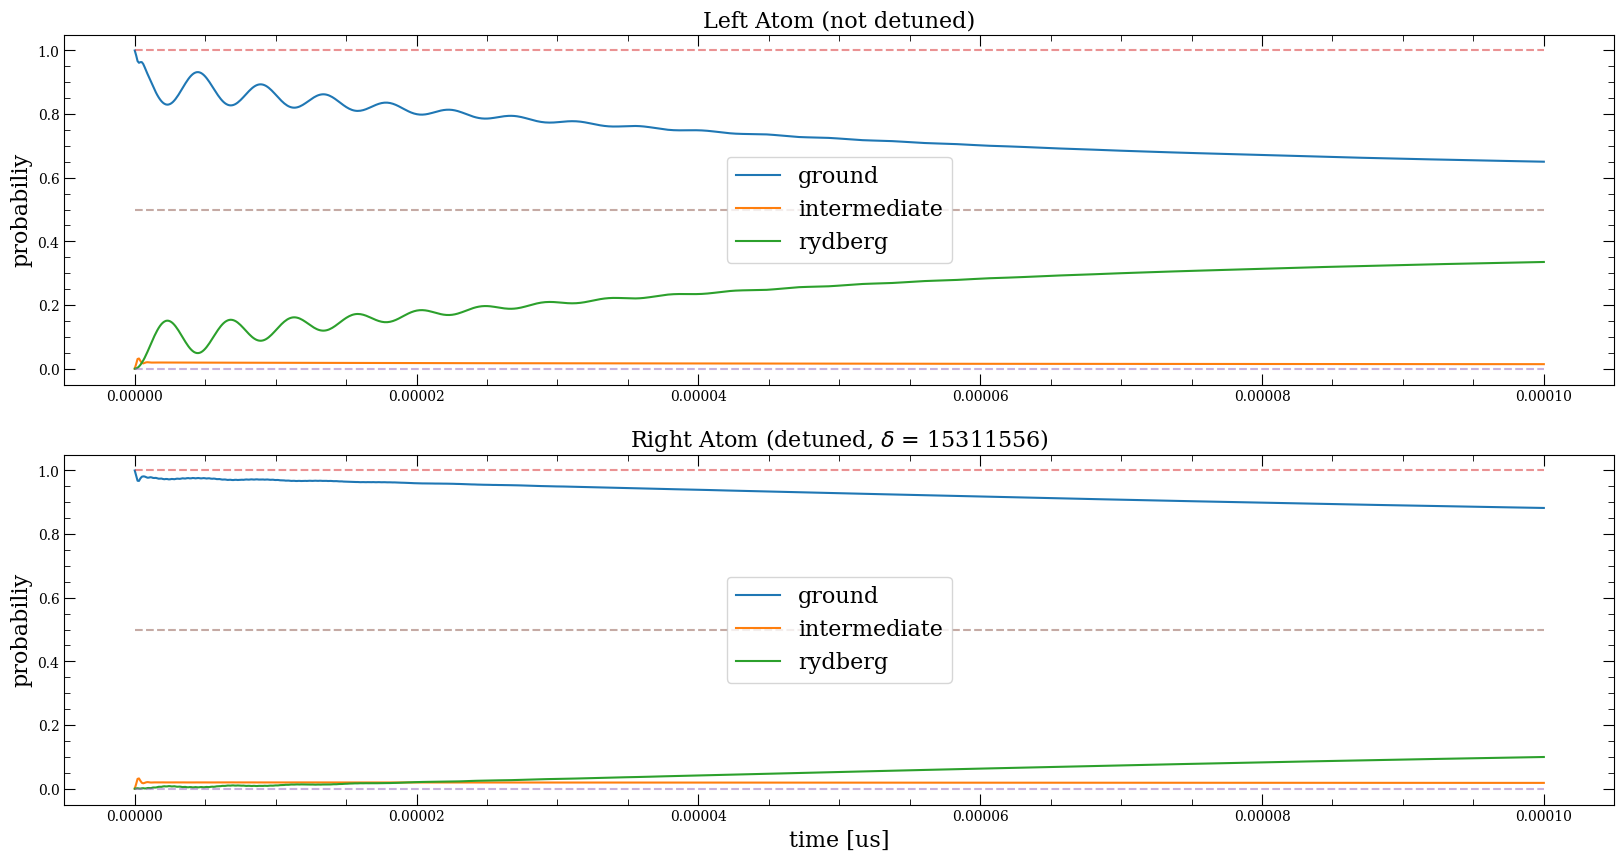

In [50]:
plt.figure(figsize=(20,10))

plt.subplot(211)
for i, label in enumerate(labels):
    plt.plot(times, p_trace_res_L[label], label=label)
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([-0.05,1.05])
plt.ylabel("probabiliy", fontsize=16)
plt.title("Left Atom (not detuned)", fontsize=16)
plt.legend(fontsize=16)

plt.subplot(212)
for i, label in enumerate(labels):
    plt.plot(times, p_trace_res_R[label], label=label)
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([-0.05,1.05])
plt.title("Right Atom (detuned, $\delta$ = %d)"%delta_R, fontsize=16)
plt.xlabel("time [us]", fontsize=16)
plt.ylabel("probabiliy", fontsize=16)
plt.legend(fontsize=16)

plt.show()

status: 100.0 %


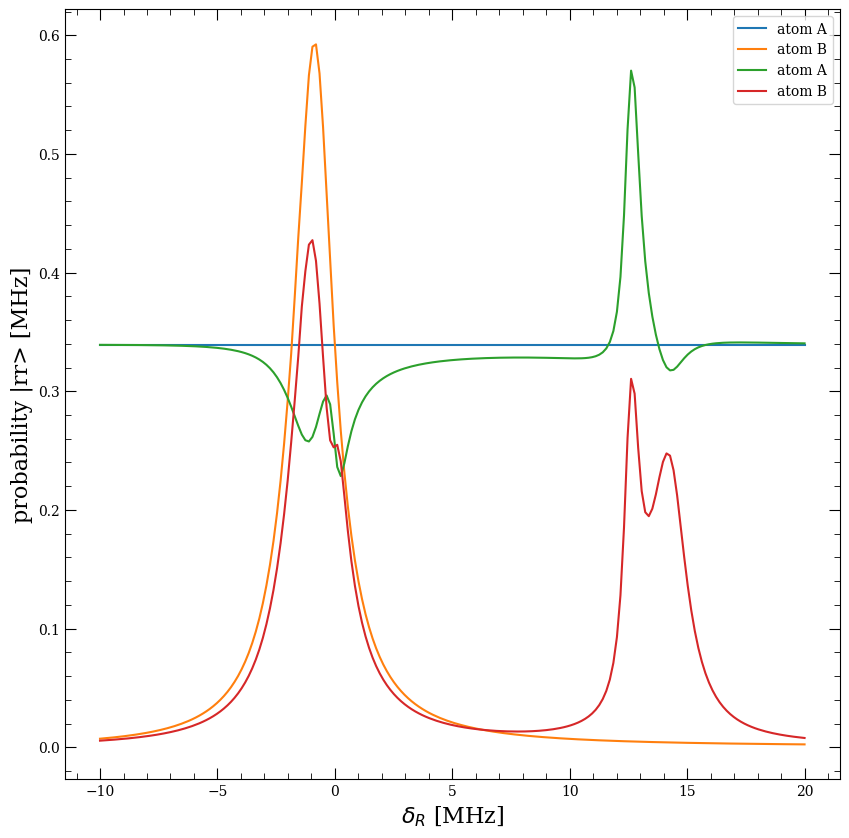

In [52]:
N_points = 200
deltas = np.linspace(-10 * scc.mega, 20 * scc.mega, N_points)

ints = [H_int(0), H_int(V_f)]

plt.figure(figsize=(10,10))

for interaction in ints:
    results = []
    for i, delta in enumerate(deltas):
        clear_output(wait=True)
        print("status: %.1f %%"%((i+1)/N_points*100))
        H_atom_A = H_0(Om_b, Om_r, Delta, 0)
        H_atom_B = H_0(Om_b, Om_r, Delta, delta)
        H = qtp.Qobj(kron(H_atom_A, np.eye(N_states)) + kron(np.eye(N_states), H_atom_B) + interaction)
        result = qtp.mesolve(H, psi0, times, c_ops = Jump_ops)
        results.append(result.states[-1])

    rho_33_R = [np.trace(np.dot(results[i],np.kron(sigma(2,2,3), np.eye(3)))) for i in range(N_points)]
    rho_33_L = [np.trace(np.dot(results[i],np.kron(np.eye(3), sigma(2,2,3)))) for i in range(N_points)]
    
    plt.plot(deltas*1e-6, rho_33_R, label = "atom A")
    plt.plot(deltas*1e-6, rho_33_L, label = "atom B")

plt.xlabel("$\delta_R$ [MHz]", fontsize=16)
plt.ylabel("probability |rr> [MHz]", fontsize=16)
plt.legend()
plt.show()